# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets"
!chmod u+r+x get_datasets.sh
!./get_datasets.sh

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
--2020-07-03 20:47:33--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2020-07-03 20:47:33 ERROR 500: Internal Server Error.

tar (child): cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'cifar-10-python.tar.gz': No such file or directory


In [1]:
!pip install scipy==1.2.1
!pip install pillow==6.1.0

     |████████████████████████████████| 24.8MB 170kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 2.1MB 2.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [2]:
%cd "/content/drive/My Drive/cs231n/assignments/assignment1"

/content/drive/My Drive/cs231n/assignments/assignment1


In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [44]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

log_learning_rates = np.array([-2.75, -2.7, -2.65, -2.6, -2.55])
log_regularization_strengths = np.array([-0.6, -0.65, -0.7, -0.75, -0.8])

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

i = 0
for log_eta in log_learning_rates:
  for log_reg in log_regularization_strengths:
    i += 1
    eta = np.exp(np.log(10)*log_eta+np.random.randn()/10)
    reg = np.exp(np.log(10)*log_reg+np.random.randn()/10)
    print("{}: {}, {}".format(i, eta, reg))

    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=eta, reg=reg,
                      num_iters=1000, verbose=True)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)

    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(eta, reg)] = (train_accuracy, val_accuracy)

    if val_accuracy > best_val:
      best_val = val_accuracy
      best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1: 0.0017338529810648007, 0.2538426177355789
iteration 0 / 1000: loss 9.004925
iteration 100 / 1000: loss 4.460867
iteration 200 / 1000: loss 3.844394
iteration 300 / 1000: loss 3.981431
iteration 400 / 1000: loss 3.829528
iteration 500 / 1000: loss 3.720599
iteration 600 / 1000: loss 3.902575
iteration 700 / 1000: loss 4.007802
iteration 800 / 1000: loss 3.740452
iteration 900 / 1000: loss 3.745269
2: 0.0018760749486994436, 0.24152286056391845
iteration 0 / 1000: loss 8.994775
iteration 100 / 1000: loss 4.535940
iteration 200 / 1000: loss 3.884389
iteration 300 / 1000: loss 3.740922
iteration 400 / 1000: loss 3.303010
iteration 500 / 1000: loss 3.807751
iteration 600 / 1000: loss 4.023604
iteration 700 / 1000: loss 3.716140
iteration 800 / 1000: loss 4.282265
iteration 900 / 1000: loss 3.775601
3: 0.0017456437325720291, 0.22429900366157712
iteration 0 / 1000: loss 8.975281
iteration 100 / 1000: loss 4.192371
iteration 200 / 1000: loss 4.086115
iteration 300 / 1000: loss 4.143128
itera

In [46]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.484


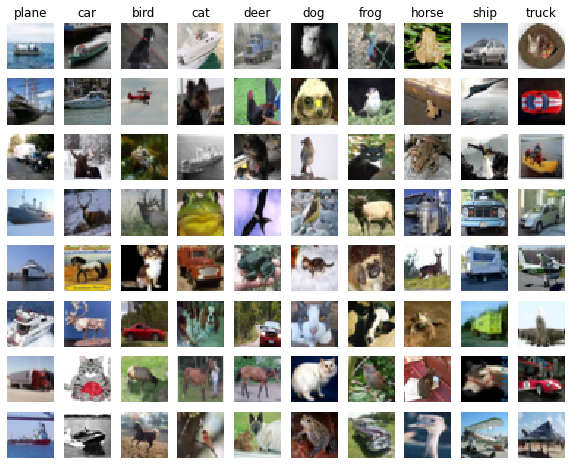

In [48]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ Generally the images that are misclassified are in some way similar to the class they are classified as. The plane and ship classes share a blue background due to the sky/ocean so there is some confusion there. Trucks and cars have similar texture so it often gets confused between them. Same with deer, cat, dog and horse. Frog seems to be misclassified due to a lot of green being present.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [49]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [64]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = [-1, -0.75, -0.5, -0.25, 0] 
regularization_strengths = [-4, -4.5, -5, -5.5, -6]

best_val = -1
results = {}
stats = {}
i = 0
for log_eta in learning_rates:
  for log_reg in regularization_strengths:
    eta = np.exp(np.log(10)*(log_eta+np.random.randn()/2))
    reg = np.exp(np.log(10)*(log_reg+np.random.randn()/2))
    
    i += 1

    print("Beginning run #{}".format(i))
    print("Eta: {}".format(eta))
    print("Regularization strength : {}".format(reg))

    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    current_stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
              num_iters=1000, batch_size=200,
              learning_rate=eta, learning_rate_decay=0.9,
              reg=reg, verbose=True)
    
    val_accuracy = current_stats["val_acc_history"][-1]
    train_accuracy = current_stats["train_acc_history"][-1]

    results[(eta, reg)] = (train_accuracy, val_accuracy)

    if val_accuracy > best_val:
      best_val = val_accuracy
      best_net = net
      for key, value in current_stats.items():
        stats[key] = value

for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                  lr, reg, train_accuracy, val_accuracy))  

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Beginning run #1
Eta: 0.37944282188908235
Regularization strength : 5.9748818451388305e-05
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.900540
iteration 200 / 1000: loss 1.611429
iteration 300 / 1000: loss 1.191573
iteration 400 / 1000: loss 1.317298
iteration 500 / 1000: loss 1.257168
iteration 600 / 1000: loss 1.236126
iteration 700 / 1000: loss 1.163364
iteration 800 / 1000: loss 1.160572
iteration 900 / 1000: loss 1.137544
Beginning run #2
Eta: 0.11493107084662942
Regularization strength : 0.00037753503948927786
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 2.302105
iteration 200 / 1000: loss 2.290720
iteration 300 / 1000: loss 1.980570
iteration 400 / 1000: loss 1.792248
iteration 500 / 1000: loss 1.538822
iteration 600 / 1000: loss 1.595458
iteration 700 / 1000: loss 1.456395
iteration 800 / 1000: loss 1.504072
iteration 900 / 1000: loss 1.182608
Beginning run #3
Eta: 0.32355672061738
Regularization strength : 7.30109215199026e-06
iteration 0 / 10

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:105: RuntimeWarning: overflow encountered in add
  exp_scores = np.exp(scores+Cs[:,np.newaxis])
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:105: RuntimeWarning: invalid value encountered in add
  exp_scores = np.exp(scores+Cs[:,np.newaxis])
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:108: RuntimeWarning: overflow encountered in subtract
  losses = -scores[range(N), y]-Cs+np.log(exp_score_sums)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:84: RuntimeWarning: invalid value encountered in less
  scores_hidden[scores_hidden<0] = 0


iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Beginning run #15
Eta: 0.6363998102038652
Regularization strength : 2.470000409623784e-07
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.567766
iteration 200 / 1000: loss 1.352155
iteration 300 / 1000: loss 1.350392
iteration 400 / 1000: loss 1.218914
iteration 500 / 1000: loss 1.241805
iteration 600 / 1000: loss 1.199413
iteration 700 / 1000: loss 1.259211
iteration 800 / 1000: loss 1.152722
iteration 900 / 1000: loss 0.869453
Beginning run #16
Eta: 2.0166118851393113
Regularization strength : 7.636959849782164e-05
iteration 0 / 1000: loss 2.302585
iteration 100 / 1000: loss 1.873718
iteration 200 / 1000: loss 1.346351
iteration 300 / 1000: loss 1.351642
iteration 400 / 1000: loss 1.476646
iteration 500 / 1000: loss 1.165558
iteration 600 / 1000: loss 1.191348
iteration 700 / 1000: loss

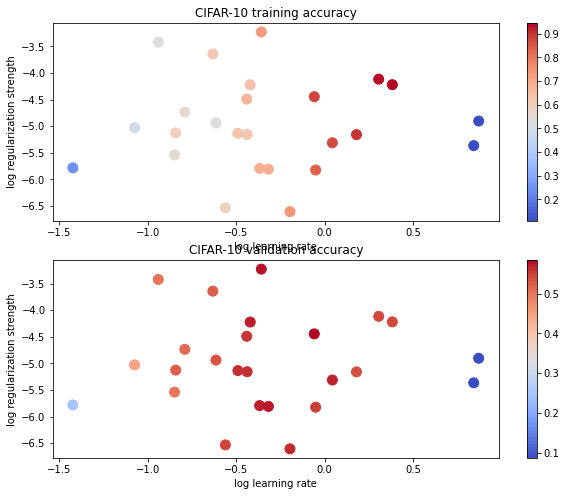

In [65]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

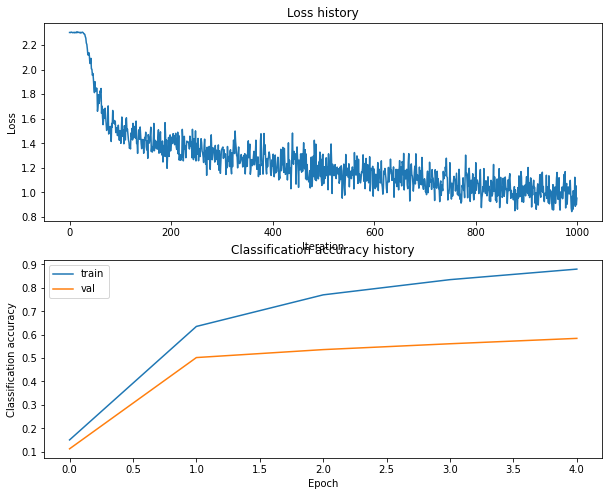

In [66]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [67]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.567
